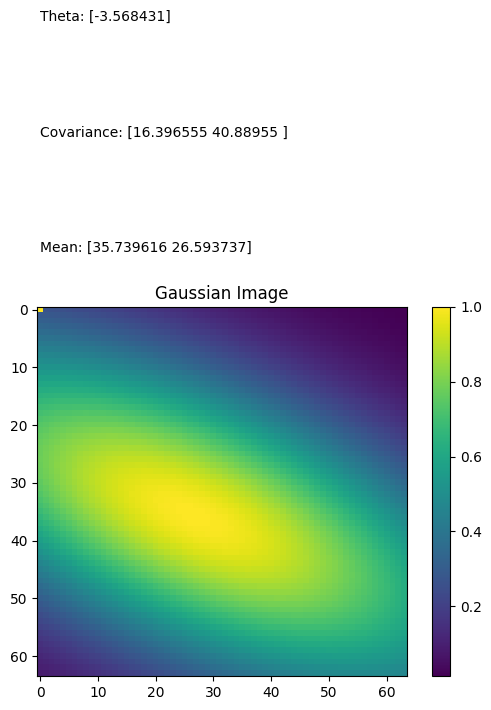

In [1]:
import torch
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

class Gaussian2DDataset(Dataset):
    def __init__(self, size=128, img_dim=64, testing = False):
        self.size = size
        self.img_dim = img_dim
        self.testing = testing
        self.images = []  # List to store generated images


    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        mean = torch.randn(2) * self.img_dim / 4 + self.img_dim / 2  # random mean
        mean=torch.abs(mean)
        cov = torch.randn(2) * self.img_dim / 4 + self.img_dim / 2 + 1e-3  # random covariance
        cov=torch.abs(cov)
        theta = torch.randn(1) * math.pi +1e-6 # random rotation angle

        x = torch.arange(self.img_dim, dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim)
        y = torch.arange(self.img_dim, dtype=torch.float32).reshape(1, -1).repeat(self.img_dim, 1)

        rota_matrix = torch.tensor([[torch.cos(theta), -torch.sin(theta)],
                                    [torch.sin(theta), torch.cos(theta)]])

        xy = torch.stack([x, y], dim=2)  # shift to mean
        mask = (xy[:, :, 0] != 0) | (xy[:, :, 1] != 0)
        xy[mask] = xy[mask] - mean #prevents NaN from the mean
        xy = torch.einsum('ijk,kl->ijl', xy, rota_matrix)  # rotation


        img = torch.exp(-0.5 * (xy[:, :, 0]**2 / (cov[0]**2+1e-3) + xy[:, :, 1]**2 / (cov[1]**2+1e-3)))


        img_rgb = torch.cat((img.unsqueeze(0), img.unsqueeze(0), img.unsqueeze(0)), dim=0)  # Convert to RGB, resnet34 takes 3 color channels, our image is grey

        img_rgb = img_rgb / img_rgb.max()
        self.images.append(img_rgb)

        if self.testing:
          return img_rgb, (mean, cov, theta)

        return img_rgb

dataset = Gaussian2DDataset(size=128, img_dim=64)
images = dataset.images


def viz_generator(image, mean=None, covariance=None, theta=None):
    """
    Displays the image and its associated mean, covariance, and theta values.

    Args:
        image (torch.Tensor): The input image to visualize.
        mean (torch.Tensor or None): Mean value. Defaults to None.
        covariance (torch.Tensor or None): Covariance value. Defaults to None.
        theta (torch.Tensor or None): Theta value. Defaults to None.
    """
    # Convert image tensor to NumPy array
    image_np = image.numpy()
    fig, ax = plt.subplots()
    #ax.imshow(image_np.transpose(1, 2, 0))
    heatmap = ax.imshow(image_np[0], cmap='viridis')
    cbar = fig.colorbar(heatmap)
    ax.set_title('Gaussian Image')

    # Check if mean, covariance, and theta are provided
    if mean is not None:
        mean_np = mean.numpy()
        ax.text(0, -10, f"Mean: {mean_np}", fontsize=10)

    if covariance is not None:
        covariance_np = covariance.numpy()
        ax.text(0, -30, f"Covariance: {covariance_np}", fontsize=10)

    if theta is not None:
        theta_np = theta.numpy()
        ax.text(0, -50, f"Theta: {theta_np}", fontsize=10)

    # Show the plot
    plt.show()



# Test the data generator
dataset = Gaussian2DDataset(size=1, img_dim=64, testing=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

for images, (mean, cov, theta) in dataloader:
    viz_generator(images[0], mean=mean[0], covariance=cov[0], theta=theta[0])




In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet34

class GaussianRN(nn.Module):
    def __init__(self, func, testing = False):
        super(GaussianRN, self).__init__()
        self.resnet = resnet34(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 5)
        self.func = func
        self.testing = testing
        self.intermediate_outputs = []


    def forward(self, x):
        x0 = self.resnet(x)

        x2 = self.func(x0)
        self.intermediate_outputs.append(x0)


        if self.testing:
          return x2, x1, x0

        return x2



class GaussianGenerator(nn.Module):
    def __init__(self, img_dim=(64,64)):
        super(GaussianGenerator, self).__init__()
        self.img_dim = img_dim

    def forward(self, params):
        batch_size = params.shape[0]
        mean_x, mean_y, cov_x, cov_y, theta = params.unbind(dim=-1)
        cov_x = torch.clamp(cov_x, min=1e-9)
        cov_y = torch.clamp(cov_y, min=1e-9)

        x = torch.arange(self.img_dim[0], dtype=torch.float32).reshape(-1, 1).repeat(1, self.img_dim[0]).to(params.device)
        y = torch.arange(self.img_dim[1], dtype=torch.float32).reshape(1, -1).repeat(self.img_dim[1], 1).to(params.device)

        x = x.repeat(batch_size, 1, 1)
        y = y.repeat(batch_size, 1, 1)

        rota_matrix = torch.stack([torch.cos(theta), -torch.sin(theta), torch.sin(theta), torch.cos(theta)], dim=-1)
        rota_matrix = rota_matrix.view(batch_size, 2, 2)

        xy = torch.stack([x - mean_x.view(-1, 1, 1), y - mean_y.view(-1, 1, 1)], dim=-1)
        xy = torch.einsum('bijk,bkl->bijl', xy, rota_matrix)

        img = torch.exp(-0.5 * (xy[:, :, :, 0]**2 / (cov_x.view(-1, 1, 1)**2 ) + xy[:, :, :, 1]**2 / (cov_y.view(-1, 1, 1)**2 )))



        return img.unsqueeze(1)




In [ ]:
for i in range(5):
  net = GaussianRN(GaussianGenerator()).cuda()
  criterion = nn.MSELoss()

  num_epochs = 1000
  lr=1e-3
  optimizer = optim.Adam(net.parameters(), lr=lr)
  #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, epochs=num_epochs, max_lr=lr, steps_per_epoch=len(dataloader))
  dataset = Gaussian2DDataset()
  dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
  print(f'RUN {i}')




  all_weights=[]
  for epoch in range(num_epochs):
      running_loss = 0.0



      for images in dataloader:
          optimizer.zero_grad()
          outputs = net(images.cuda())


          loss = criterion(outputs, images.cuda())  # compare outputs with input images for reconstruction
          loss.backward()
          clip_grad_norm_(net.parameters(), 1)

          optimizer.step()
          #scheduler.step()

          running_loss += loss.item()

      max_weight = max(p.data.abs().max().cpu() for p in net.parameters())
      all_weights.append(max_weight)
      average_loss = running_loss / len(dataloader)

      print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}")






Streaming output truncated to the last 5000 lines.
Epoch [5/1000], Loss: 0.3458654582500458
Epoch [6/1000], Loss: 0.37401530146598816
Epoch [7/1000], Loss: 0.3435966372489929
Epoch [8/1000], Loss: 0.33551129698753357
Epoch [9/1000], Loss: 0.3233606815338135
Epoch [10/1000], Loss: 0.3053441047668457
Epoch [11/1000], Loss: 0.27133235335350037
Epoch [12/1000], Loss: 0.24824568629264832
Epoch [13/1000], Loss: 0.24478211998939514
Epoch [14/1000], Loss: 0.2335764616727829
Epoch [15/1000], Loss: 0.24290955066680908
Epoch [16/1000], Loss: 0.21663054823875427
Epoch [17/1000], Loss: 0.21964268386363983
Epoch [18/1000], Loss: 0.17716121673583984
Epoch [19/1000], Loss: 0.19130538403987885
Epoch [20/1000], Loss: 0.17447498440742493
Epoch [21/1000], Loss: 0.15234538912773132
Epoch [22/1000], Loss: 0.1921314001083374
Epoch [23/1000], Loss: 0.16662876307964325
Epoch [24/1000], Loss: 0.17421571910381317
Epoch [25/1000], Loss: 0.19423769414424896
Epoch [26/1000], Loss: 0.1858230084180832
Epoch [27/1000]

In [ ]:
with torch.no_grad():
  dev=torch.device("cuda")
  data = next(iter(dataloader))
  data_ = data.cpu()
  optimizer.zero_grad()
  outputs = net(data.to('cuda')).cpu()

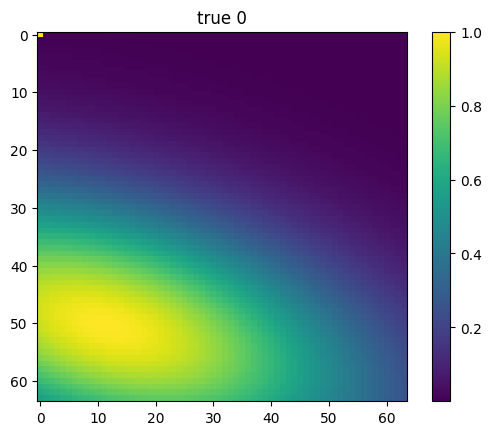

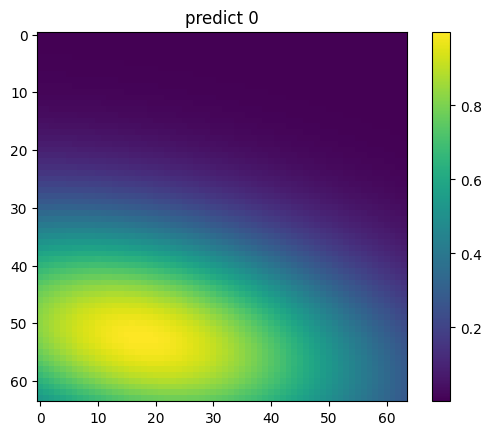

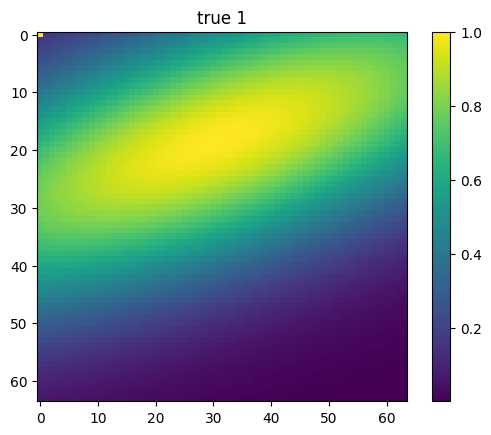

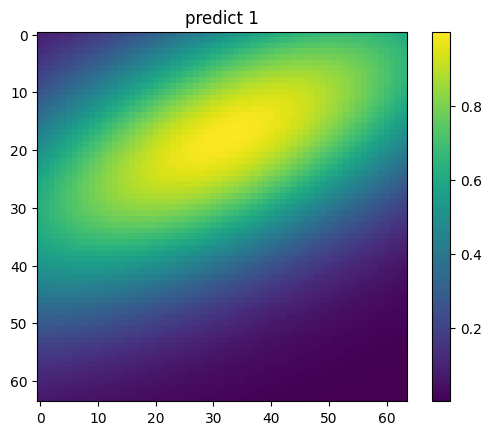

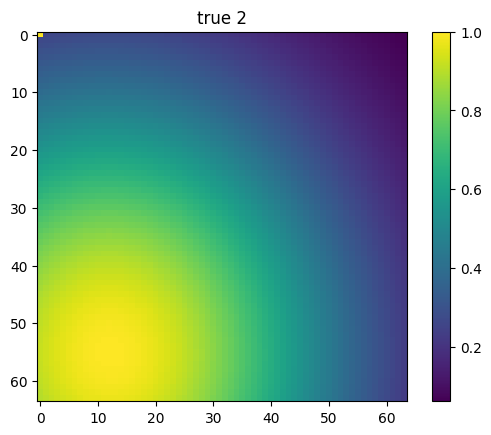

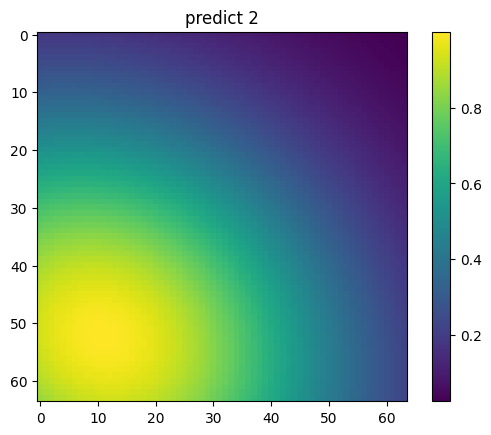

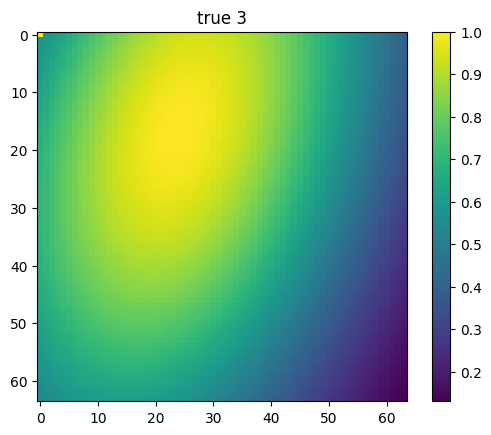

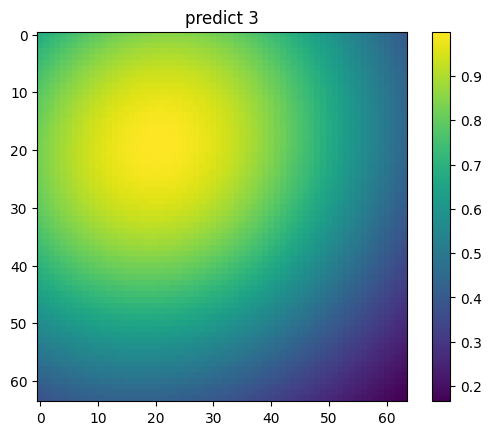

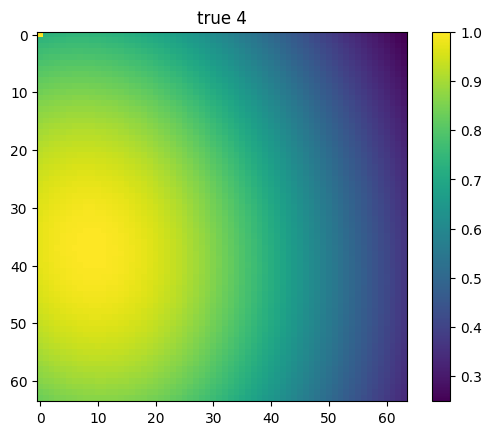

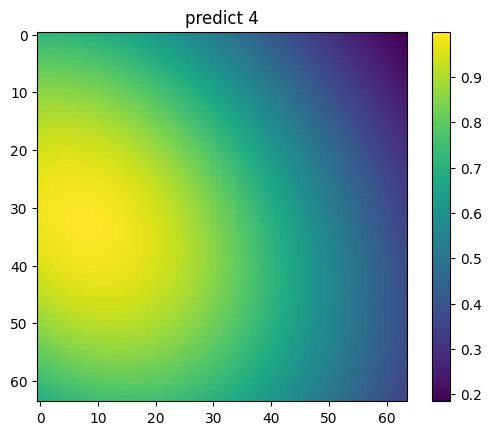

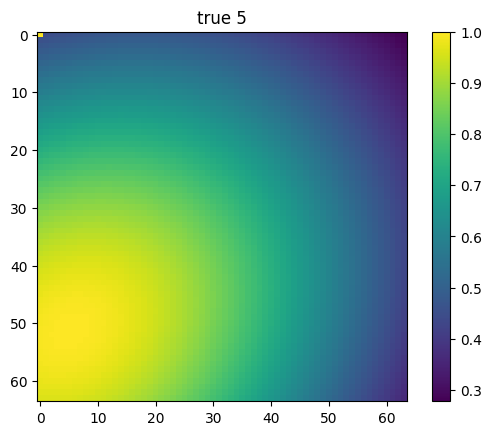

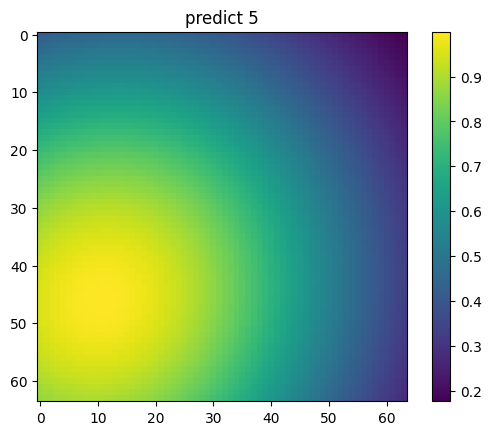

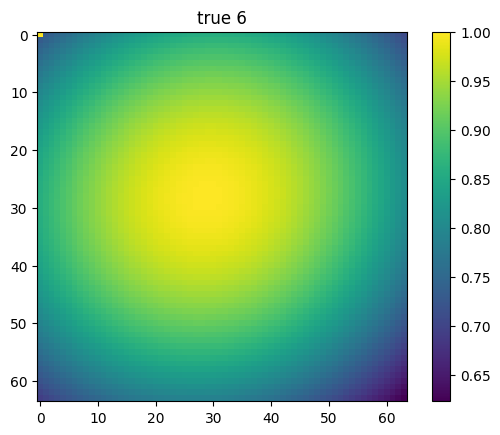

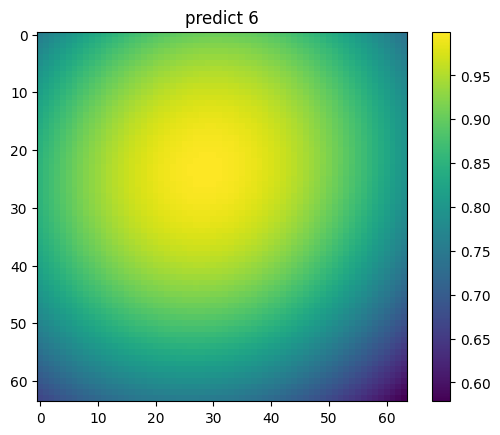

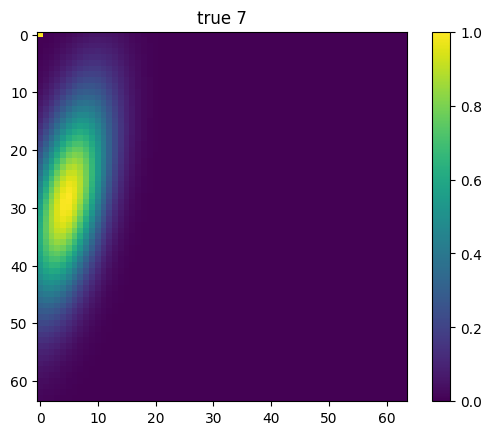

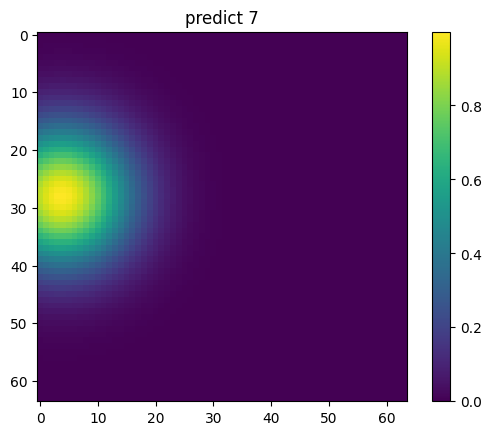

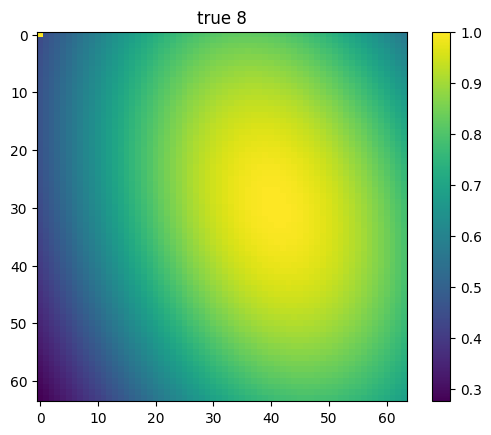

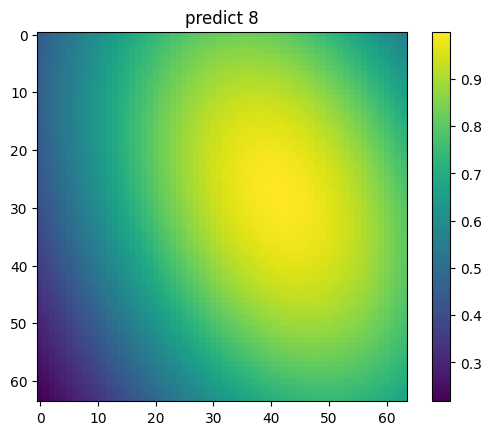

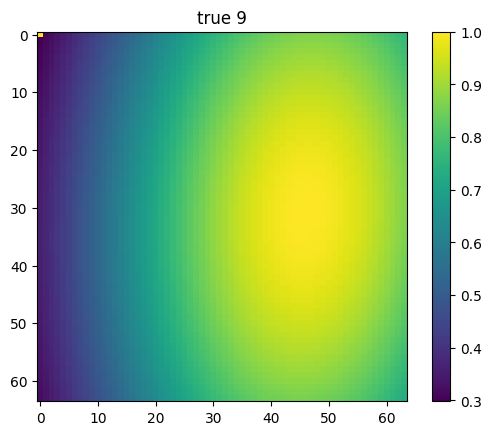

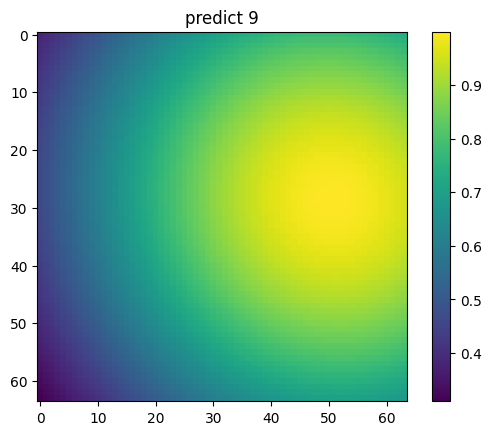

In [ ]:
import matplotlib.pyplot as plt
for i in range(10):
  plt.figure()
  plt.imshow(data[i,0])
  plt.title(f'true {i}')
  plt.colorbar()
  plt.savefig(f'data {i}')
  plt.show()


  plt.figure()
  plt.imshow(outputs[i,0])
  plt.title(f'predict {i}')
  plt.colorbar()
  plt.savefig(f'predict {i}')
  plt.show()

